Machine Leaning Course vol.6
# 分類問題

前回までは回帰問題に対してのアプローチを勉強してきました。

今回からは、分類問題を勉強していきます。

まずは、数回に渡って使用するあやめデータセットについて見ていきます。

In [82]:
# 必要モジュールのインポートをしておきます

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
sns.set_style('whitegrid')

## データセット 
機械学習のサンプルデータとして非常によく使われるデータセットがあります。
それが、[Iris（アヤメ）のデータ](http://en.wikipedia.org/wiki/Iris_flower_data_set) です。

このデータセットは、イギリスの統計学者ロナルド・フィッシャーによって、1936年に紹介されました。

3種類のアヤメについて、それぞれ50サンプルのデータがあります。それぞれ、Iris setosa、Iris virginica、Iris versicolorという名前がついています。全部で150のデータになっています。4つの特徴量が計測されていて、これが説明変数になります。4つのデータは、花びら（petals）と萼片（sepals）の長さと幅です。

[花びら（petals）と萼片（sepals）](https://ja.wikipedia.org/wiki/%E8%90%BC)

![](https://s3.amazonaws.com/ai-standard/pic6-1.png)

In [83]:
from sklearn.datasets import load_iris

# Irisデータのロード
iris = load_iris()

X = iris.data
y = iris.target
feature_names = iris.feature_names

#### Irisデータの表示

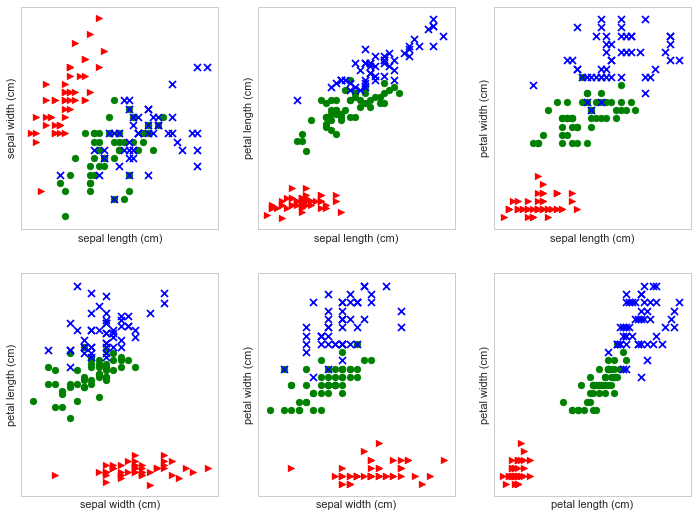

In [84]:
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
plt.figure(figsize=(12, 9))

for i, (p0, p1) in enumerate(pairs):
    plt.subplot(2, 3, i + 1)
    for t, marker, c in zip(list(range(3)), ">ox", "rgb"):
        plt.scatter(X[iris.target == t, p0], X[iris.target == t, p1], marker=marker, c=c)
    plt.xlabel(feature_names[p0])
    plt.ylabel(feature_names[p1])
    plt.xticks([])
    plt.yticks([])

plt.show()

### 単純パーセプトロン
最初に勉強する分類アルゴリズムは、「単純パーセプトロン」と呼ばれるものです。
（以降、パーセプトロンと記述する場合は、単純パーセプトロンのことを指します）

パーセプトロンは今後学習するアルゴリズムへと繋がっていく基礎的な機械学習アルゴリズムです。

まずは、パーセプトロンの基本的な概念を理解しましょう。

パーセプトロンは、ある多次元のデータを２つのカテゴリに分類するアルゴリズムです。

分類問題は、__以下の様なデータを区切る線をいかに見つけるか？__ということに着目したものです。
単純に２次元の場合を考えてみましょう。

![](https://s3.amazonaws.com/ai-standard/pic6-2.png)

普通に考えると、以下のように区切るはずです。

![](https://s3.amazonaws.com/ai-standard/pic6-3.png)

では、機械にこの線を見つけさせるためにはどうしたらいいでしょうか？

パーセプトロンの場合、この線は「ベクトル」になります。
正確には、__重みベクトルを法線とする直線__です。

重みベクトルを$w$、特定の入力値を$x$を以下に定義します。
$$
  w = \left[
    \begin{array}{r}
      w_1 \\
      w_2 \\
      \vdots \\
      w_i
    \end{array}
  \right]
$$

$$
  x = \left[
    \begin{array}{r}
      x_1 \\
      x_2 \\
      \vdots \\
      x_i
    \end{array}
  \right]
$$

そうすると、直線の方程式はこのように表せます。
$$wx=0$$

実ベクトルの内積は、各要素の積を足し上げたものなので、
$$wx=\sum^{n}_{i=1}w_ix_i = 0$$
このようにも表せる。（nは次元数）

![](https://s3.amazonaws.com/ai-standard/pic6-4.png)

青の点を１クラス、赤の点を-1クラスとする。

そうすると、サンプル$x^(i)$と重みの掛け合わせが、０より大きければ１クラスと予想し、それ以外の場合は-1クラスと予想することになる。

まとめると、以下と定義できる。

$$ z = w_0x_0 + w_1x_1 + … + w_mx_m = w^Tx $$

$$ \Phi(z) =\begin{eqnarray}
\left\{
\begin{array}{l}
1\ \ \ \ \ (z\geq0) \\
-1\ \ (z < 0)
\end{array}
\right.
\end{eqnarray}
$$

式を定義することが出来たので、あとはいかにして$w$を推定するかを考える。

パーセプトロンの学習規則はきわめて単純で、以下の手順にまとめることができる。

##### 【パーセプトロンの学習】
1. 重みを０または値の小さい乱数で初期化する。
2. トレーニングサンプル$x^{(i)}$ごとに以下の手順を実行する
  1. 出力値$\Phi(z)$を計算する
  2. 重みを更新する
  3. 全教師データについて正しい出力が行われたら繰り返し終了


学習規則は以下のように定義できる。

$$w_j := w_j + \alpha (y^{(i)} -  \Phi(z^{(i)})) x^{(i)}_j$$

$　\alpha$は学習率、$i$はi番目のトレーニングサンプルである。

重みベクトルのwは同時に更新されていることに注意しよう。

では、実際にどのように更新が行われていくかを、数字を代入していきながら見ていく。

#### パターン①　「予想値が正解の場合」
$$\alpha (y^{(i)} -  \Phi(z^{(i)})) x^{(i)}_j = \alpha(-1 - (-1))x^{(i)}_j = 0$$

$$\alpha (y^{(i)} -  \Phi(z^{(i)})) x^{(i)}_j = \alpha(1 - (1))x^{(i)}_j = 0$$

#### パターン②　「予想値が不正解の場合」
$$\alpha (y^{(i)} -  \Phi(z^{(i)})) x^{(i)}_j = \alpha(1 - (-1))x^{(i)}_j = \alpha(2)x^{(i)}_j $$

$$\alpha (y^{(i)} -  \Phi(z^{(i)})) x^{(i)}_j = \alpha(-1 - (1))x^{(i)}_j = \alpha(-2)x^{(i)}_j $$

このように、合ってた場合は値は更新しないが、間違っているとそれに応じた値で更新される。

### ※ 注意
__パーセプトロンの収束が保証されるのは、２つのクラスが線形分離可能で、学習率が十分に小さい場合のみに限られます。__

線形分離可能とは、データを直線で区切れるかどうか？を表します。
![](https://s3.amazonaws.com/ai-standard/pic6-5.png)

2つのクラスを線形の境界線で分離出来ない場合は、データセットに対するトレーニングの最大回数（エポック）や誤分類の最大数を設定して対応する。

そうしないと、パーセプトロンはいつまでも重みを更新し続けることになる。

In [85]:
import pandas as pd

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header=None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


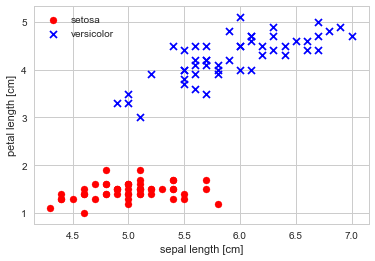

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

# 1-100行目の目的変数の抽出
y = df.iloc[0:100, 4].values

# Iris-setosaを-1、Iris-virginicaを１に変換
y = np.where(y=="Iris-setosa", -1, 1)

# 1-100行目の１，３列の抽出
X = df.iloc[0:100,[0,2]].values

# プロット
plt.scatter(X[:50,0],X[:50,1], color="red", marker="o", label="setosa")
plt.scatter(X[50:100,0],X[50:100,1],color="blue", marker="x",label="versicolor")
plt.xlabel("sepal length [cm]")
plt.ylabel("petal length [cm]")
plt.legend(loc="upper left")
plt.show()

In [87]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, n_iter=10)
ppn.fit(X, y)

Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      n_iter=10, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [88]:
# ２次元データの決定曲線をプロットする関数
def plot_decision_regions(X, y, classifier, resolution=0.02):
    from matplotlib.colors import ListedColormap
    markers = ("s", "x", "o", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min()-1 , X[:, 0].max() +1
    x2_min, x2_max = X[:, 1].min()-1 , X[:, 1].max() +1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx),marker=markers[idx], label=cl)

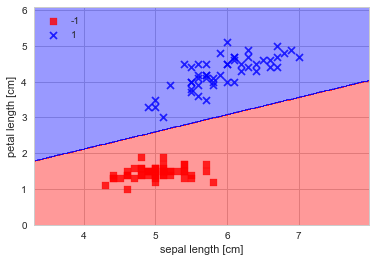

In [89]:
# プロット
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel("sepal length [cm]")
plt.ylabel("petal length [cm]")
plt.legend(loc="upper left")
plt.show()

決定曲線をプロットし、学習結果を可視化することができた。

見て分かるように、きちんと分類できる直線を学習している。（上がsetosa、下がvirginica）

以上より、Iris setosa、Iris virginica、Iris versicolorの中でIris setosaとIris virginicaは１００％分類できることが可能となった。

次は、全体のデータセットを使って学習をさせてみます。

## データの前処理

In [90]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target

#### データの分割
データを、トレーニングデータセットとテストデータセットに分割します。

scikit-learnには、データ分割の便利なモジュールがあるのでこれをつかいましょう。


~~~
train_test_split(特徴量[X], ラベル[Y], test_size= [テストデータの割合], random_state=[乱数生成のシード値])
~~~

In [91]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### データの整形
データはcmで統一されていますが、まずは平均を0、分散を1にする「標準化」という作業をしていきます。

##### 標準化ってなんでするの？？
標準化されてない生のデータセットは、数値の単位がバラバラ（mとｋｇ）だったらり、大きさが極端に違う（0.001と10000）などの特徴を持っていることが多いです。

このまま扱うと、特定の特徴量の影響が強く出てしまう場合があります。そこで、それぞれの特徴量のスケールを同じにそろえる作業（標準化）が必要になります。

これをすることによって、最適なパフォーマンスを実現するのに一歩近づくことになります。

In [92]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# トレーニングデータの平均と標準偏差を計算
scaler.fit(X_train)

# 平均と標準偏差を用いて標準化
X_train_std = scaler.transform(X_train)
X_test_std =  scaler.transform(X_test)

scikit-learnでは他の学習器と同じインタフェースで「標準化」が実装されています。
学習したモデルを使ってデータを変換する（標準化する）ときはpredict( )ではなく、transform( )というメソッドが定義されています。

【注意点】
テストデータを標準化するときは、同じスケーリングパラメータを適応すること。
これは、トレーニングデータとテストデータの値を相互に比較できるようにするためです。

#### パーセプトロンの適応

In [93]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter=40, eta0=0.1, random_state=0, shuffle=True)
ppn.fit(X_train_std,y_train)
y_pred = ppn.predict(X_test_std)

#### 性能指標
分類問題の性能指標として、正解率が使われることが多い。

scikit-learnではmetricsモジュールに色々な性能指標がある。

今回は、accuracy_scoreを使用する。

In [94]:
from sklearn.metrics import accuracy_score

print("Accuracy: %.2f" % accuracy_score(y_test, y_pred))

Accuracy: 0.91


### プロットの可視化

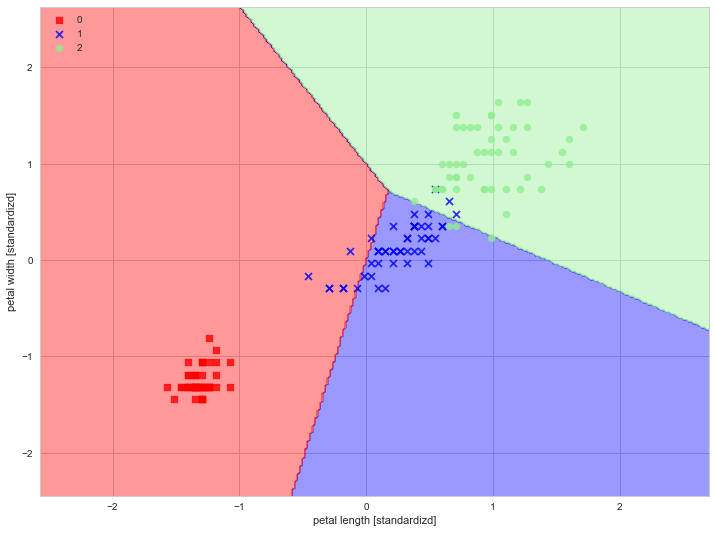

In [95]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plt.figure(figsize=(12, 9))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn)
plt.xlabel("petal length [standardizd]")
plt.ylabel("petal width [standardizd]")

plt.legend(loc = "upper left")
plt.show()

見て分かるように、３つの品種を線形の決定境界で完全に区切ることはできません。

パーセプトロンは線形分離可能なデータセットに対してしか収束しません。ですから、この手法ではあやめデータセットを完全に分離することは不可能です。

次以降では、クラスが完全に分離できない場合であってもコストの最初値に収束するような、強力な分類アルゴリズムを勉強していきます。